In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For natural language processing and model building
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load the datasets
apps_df = pd.read_csv('.\\apps.csv')
reviews_df = pd.read_csv('.\\user_reviews.csv')

# Display first few rows of each dataset
print("Apps Data Sample:")
print(apps_df.head())
print("\nUser Reviews Data Sample:")
print(reviews_df.head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akank\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Apps Data Sample:
   Unnamed: 0                                                App  \
0           0     Photo Editor & Candy Camera & Grid & ScrapBook   
1           1                                Coloring book moana   
2           2  U Launcher Lite – FREE Live Cool Themes, Hide ...   
3           3                              Sketch - Draw & Paint   
4           4              Pixel Draw - Number Art Coloring Book   

         Category  Rating  Reviews  Size     Installs  Type Price  \
0  ART_AND_DESIGN     4.1      159   19M      10,000+  Free     0   
1  ART_AND_DESIGN     3.9      967   14M     500,000+  Free     0   
2  ART_AND_DESIGN     4.7    87510  8.7M   5,000,000+  Free     0   
3  ART_AND_DESIGN     4.5   215644   25M  50,000,000+  Free     0   
4  ART_AND_DESIGN     4.3      967  2.8M     100,000+  Free     0   

  Content Rating                     Genres      Last Updated  \
0       Everyone               Art & Design   January 7, 2018   
1       Everyone  Art & Desi

In [2]:
# Remove commas and plus signs in the 'Installs' column and convert to integer
apps_df['Installs'] = apps_df['Installs'].str.replace('[+,]', '', regex=True).astype(int)

# Check for missing values in apps dataset
print("Missing values in apps_df:")
print(apps_df.isnull().sum())

Missing values in apps_df:
Unnamed: 0           0
App                  0
Category             0
Rating            1463
Reviews              0
Size              1227
Installs             0
Type                 1
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          8
Android Ver          2
dtype: int64


In [3]:
# Calculate median rating for imputation
median_rating = apps_df['Rating'].median()

# Replace missing values by reassigning the filled series
apps_df['Rating'] = apps_df['Rating'].fillna(median_rating)
apps_df['Size'] = apps_df['Size'].fillna("Unknown")

# For the 'Type' column, drop rows with missing values since it's only one missing row
apps_df = apps_df.dropna(subset=['Type'])

# Replace missing values for 'Current Ver' and 'Android Ver'
apps_df['Current Ver'] = apps_df['Current Ver'].fillna("Unknown")
apps_df['Android Ver'] = apps_df['Android Ver'].fillna("Unknown")

# Verify the cleaning results
print("Missing values in apps_df after cleaning:")
print(apps_df.isnull().sum())


Missing values in apps_df after cleaning:
Unnamed: 0        0
App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
dtype: int64


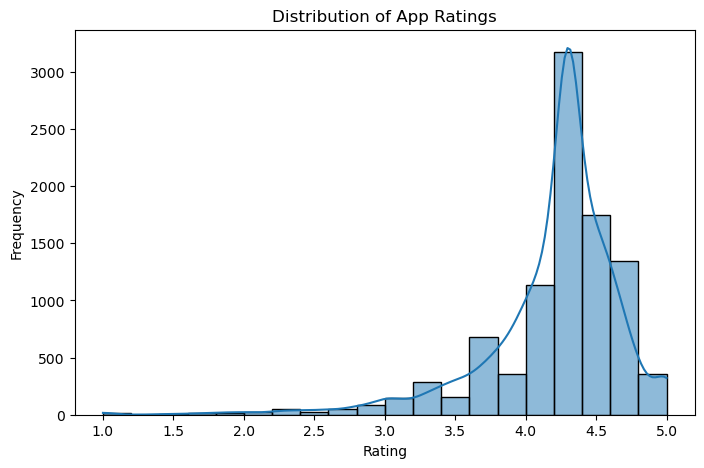

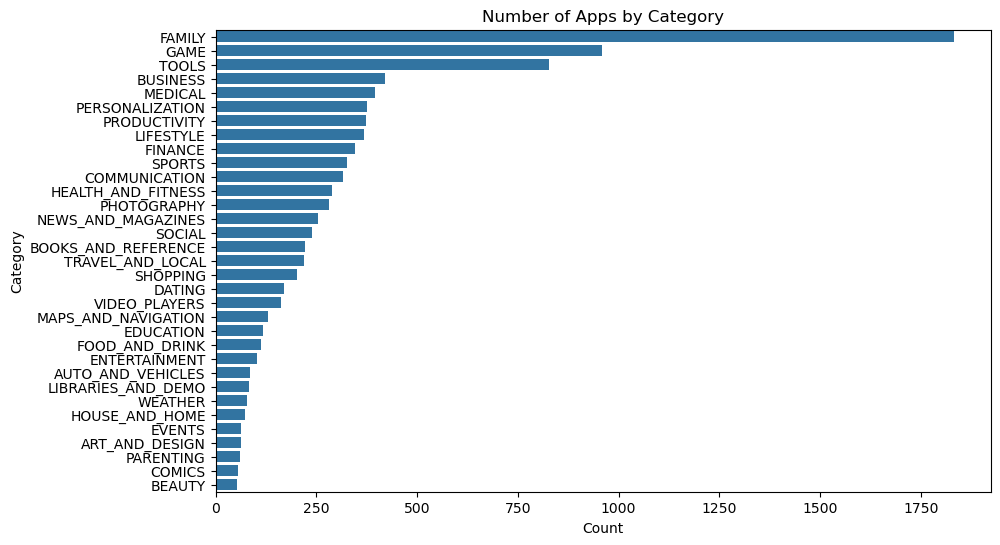

In [4]:
# Distribution of app ratings
plt.figure(figsize=(8, 5))
sns.histplot(apps_df['Rating'], bins=20, kde=True)
plt.title("Distribution of App Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

# Count of apps per category (using a subset for clarity)
plt.figure(figsize=(10, 6))
sns.countplot(y='Category', data=apps_df, order=apps_df['Category'].value_counts().index)
plt.title("Number of Apps by Category")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()

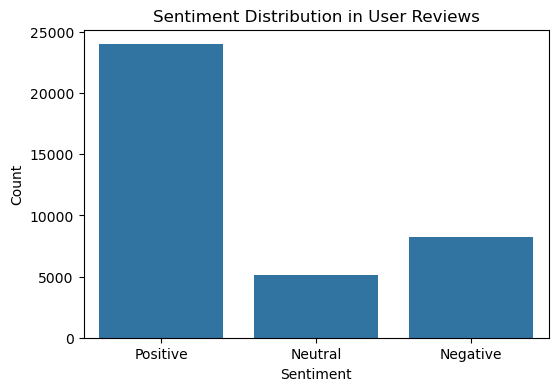

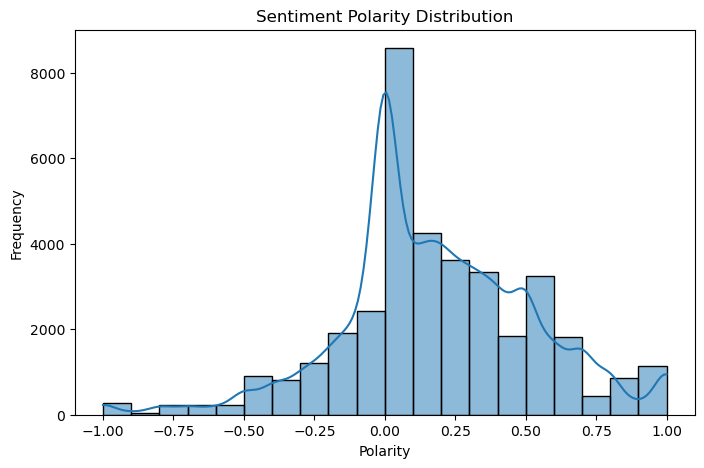

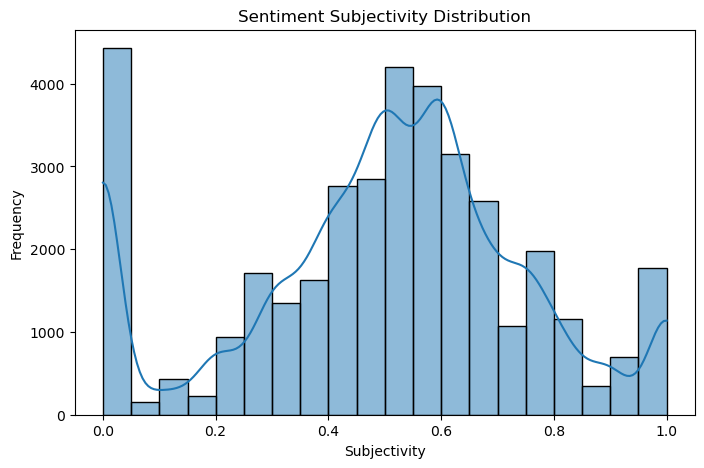

In [5]:
# Count plot for sentiment distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Sentiment', data=reviews_df)
plt.title("Sentiment Distribution in User Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Distribution of sentiment polarity
plt.figure(figsize=(8, 5))
sns.histplot(reviews_df['Sentiment_Polarity'], bins=20, kde=True)
plt.title("Sentiment Polarity Distribution")
plt.xlabel("Polarity")
plt.ylabel("Frequency")
plt.show()

# Distribution of sentiment subjectivity
plt.figure(figsize=(8, 5))
sns.histplot(reviews_df['Sentiment_Subjectivity'], bins=20, kde=True)
plt.title("Sentiment Subjectivity Distribution")
plt.xlabel("Subjectivity")
plt.ylabel("Frequency")
plt.show()


In [6]:
# Step 1: Drop rows with missing review text or sentiment
reviews_df = reviews_df.dropna(subset=['Translated_Review', 'Sentiment'])

# Step 2: Convert review text to lowercase and ensure it's a string
reviews_df['Translated_Review'] = reviews_df['Translated_Review'].str.lower().astype(str)

# Optional: Fill any remaining NaNs just in case (should be redundant after dropna)
reviews_df['Translated_Review'] = reviews_df['Translated_Review'].fillna("")

# Verify there are no NaNs in the review column
print("Number of NaNs in Translated_Review:", reviews_df['Translated_Review'].isna().sum())

# Step 3: Prepare the features and labels
X = reviews_df['Translated_Review']
y = reviews_df['Sentiment']

# Optional: Check that all documents are strings (should be, but it's a good safety check)
assert X.apply(lambda x: isinstance(x, str)).all(), "Not all entries in X are strings."

# Step 4: Split the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Vectorize the text using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Fit and transform the training data; transform the test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("TF-IDF vectorization complete. Shape of training data:", X_train_tfidf.shape)

Number of NaNs in Translated_Review: 0
TF-IDF vectorization complete. Shape of training data: (29941, 5000)


In [7]:
# Initialize and train the model
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_tfidf)

Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.44      0.58      1653
     Neutral       0.86      0.10      0.18      1049
    Positive       0.72      0.99      0.83      4784

    accuracy                           0.74      7486
   macro avg       0.82      0.51      0.53      7486
weighted avg       0.78      0.74      0.69      7486

Confusion Matrix:


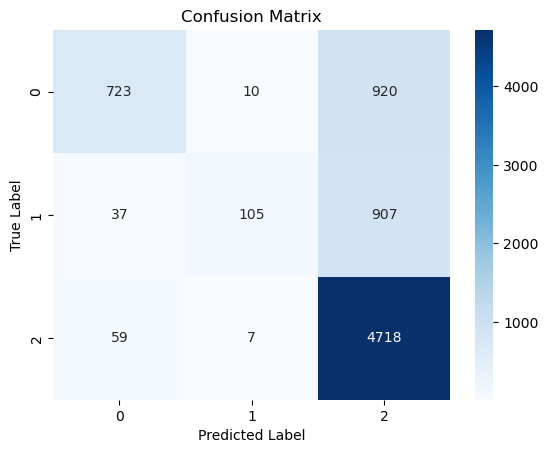

Model Accuracy: 0.74


In [8]:
# Evaluation metrics and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

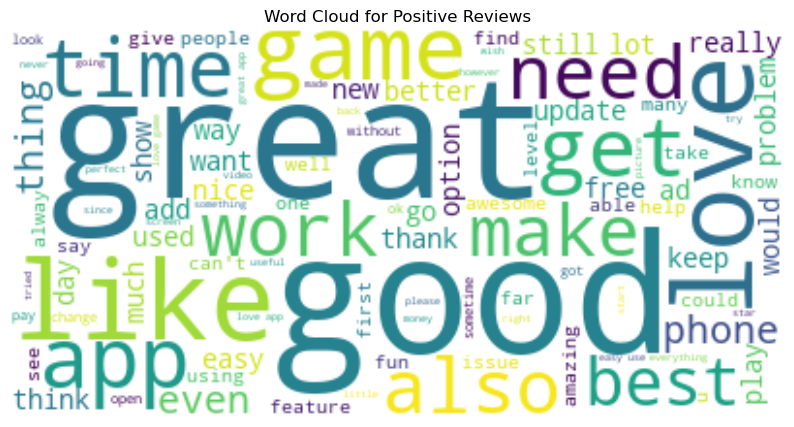

In [11]:
from wordcloud import WordCloud

# Generate a word cloud for positive reviews
positive_reviews = ' '.join(reviews_df[reviews_df['Sentiment'] == 'Positive']['Translated_Review'])
wordcloud = WordCloud(stopwords=stopwords.words('english'), background_color='white', max_words=100).generate(positive_reviews)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Positive Reviews")
plt.show()

In [12]:
# Merge the Two Datasets on the 'App' Column
# -------------------------------
merged_df = pd.merge(reviews_df, apps_df, on="App", how="left")

# Check the first few rows of the merged dataset
print("Merged Data Sample:")
print(merged_df.head())

Merged Data Sample:
                     App                                  Translated_Review  \
0  10 Best Foods for You  i like eat delicious food. that's i'm cooking ...   
1  10 Best Foods for You    this help eating healthy exercise regular basis   
2  10 Best Foods for You         works great especially going grocery store   
3  10 Best Foods for You                                       best idea us   
4  10 Best Foods for You                                           best way   

  Sentiment  Sentiment_Polarity  Sentiment_Subjectivity  Unnamed: 0  \
0  Positive                1.00                0.533333      1393.0   
1  Positive                0.25                0.288462      1393.0   
2  Positive                0.40                0.875000      1393.0   
3  Positive                1.00                0.300000      1393.0   
4  Positive                1.00                0.300000      1393.0   

             Category  Rating  Reviews  Size  Installs  Type Price  \
0  HEALT

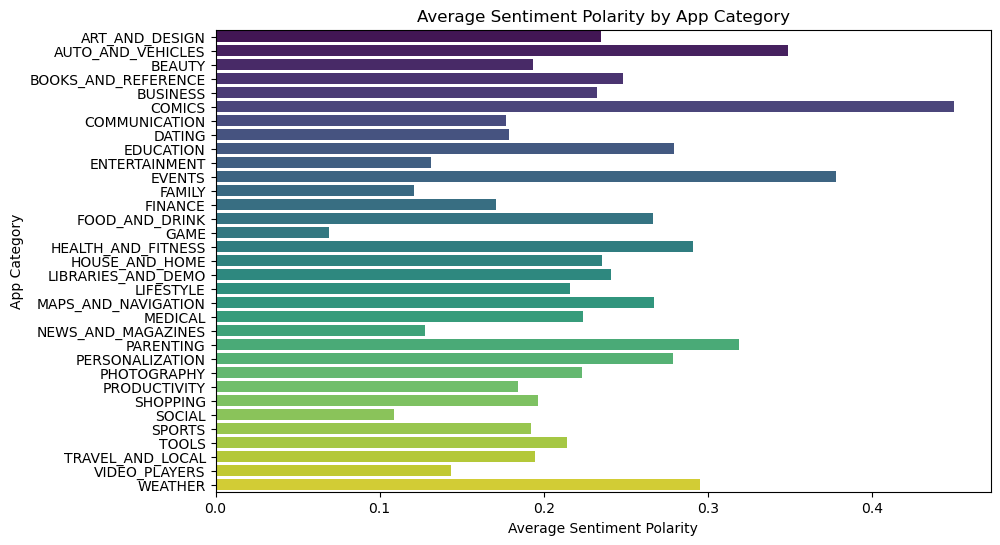

In [15]:
# Calculate average sentiment polarity by category
category_sentiment = merged_df.groupby('Category')['Sentiment_Polarity'].mean().reset_index()

# Plot the results
plt.figure(figsize=(10,6))
sns.barplot(x='Sentiment_Polarity', y='Category', data=category_sentiment, hue='Category', palette='viridis')
plt.legend([], [], frameon=False)
plt.title("Average Sentiment Polarity by App Category")
plt.xlabel("Average Sentiment Polarity")
plt.ylabel("App Category")
plt.show()

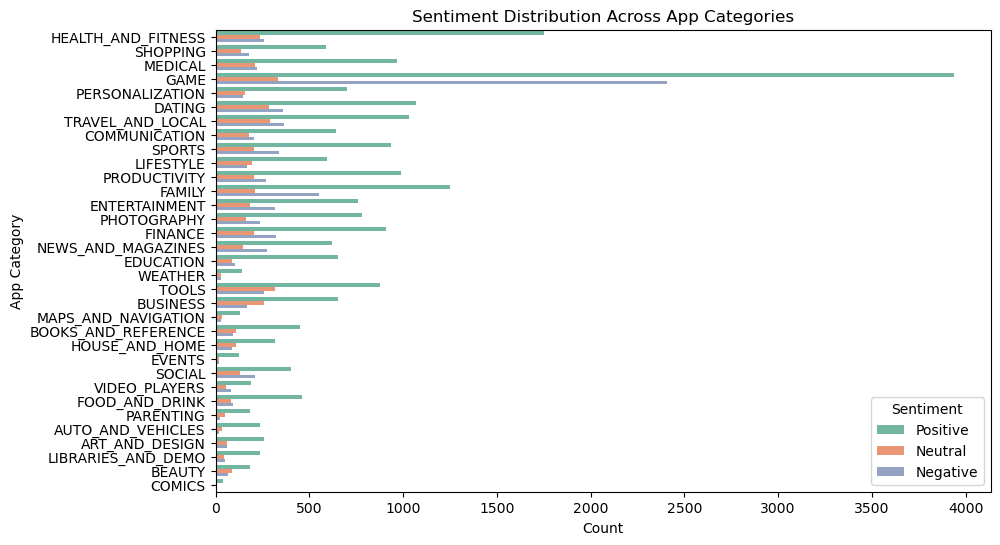

In [14]:
plt.figure(figsize=(10,6))
sns.countplot(y='Category', hue='Sentiment', data=merged_df, palette='Set2')
plt.title("Sentiment Distribution Across App Categories")
plt.xlabel("Count")
plt.ylabel("App Category")
plt.legend(title="Sentiment")
plt.show()